In [108]:
import sys
import os
import numpy as np
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, brier_score_loss, log_loss)
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline
from betacal import BetaCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier
mli.__version__

'1.0.4'

In [2]:
from utilities import bs_calibrate, bs_results, utils

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

## Training results

In [4]:
results_df = pd.read_csv("../results/bs_training_data/csv/final_results.csv")

In [5]:
results_df.columns

Index(['Models', 'Accuracy', 'Acc_Std', 'Acc_95%CI', 'Precision',
       'Precision_Std', 'Precision_95%CI', 'Recall', 'Recall_Std',
       'Recall_95%CI', 'F1Score', 'F1Score_Std', 'F1Score_95%CI', 'AUC',
       'AUC_std', 'AUC_95%CI'],
      dtype='object')

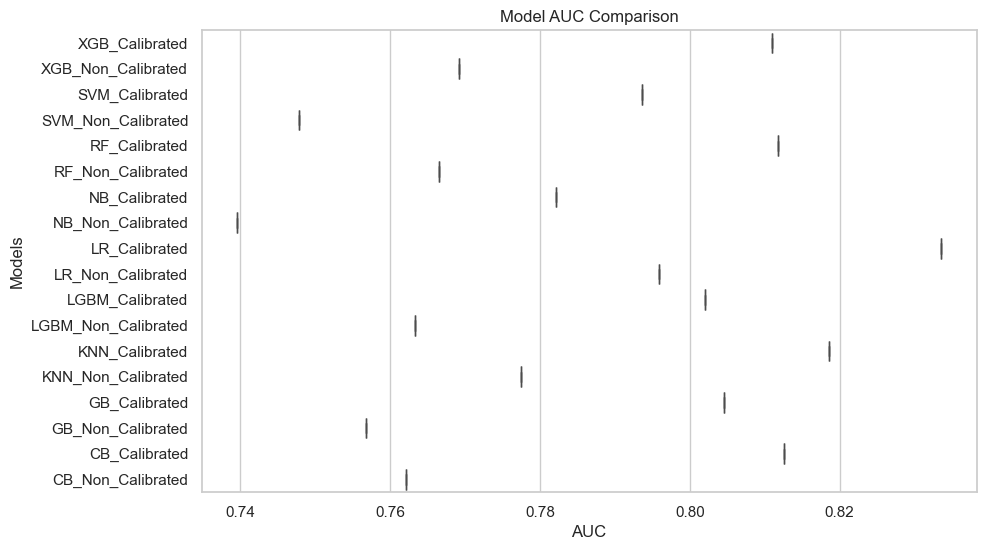

In [6]:
# Plot AUC
plt.figure(figsize=(10, 6))
sns.boxplot(x='AUC', y='Models', data=results_df)
plt.title('Model AUC Comparison')
plt.show()

In [7]:
filtered_models = results_df[results_df['AUC'] >= 0.80]
filtered_models.Models

0      XGB_Calibrated
4       RF_Calibrated
8       LR_Calibrated
10    LGBM_Calibrated
12     KNN_Calibrated
14      GB_Calibrated
16      CB_Calibrated
Name: Models, dtype: object

## Load the data

In [8]:
# df = pd.read_csv("../dibh_clinical_only/original_training_data.csv")
df = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

# df_internal_val = pd.read_csv("../dibh_clinical_only/final_internal_validation13052024.csv")
df_internal_val = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']


## Load the model information for all ML models

In [9]:
xgb_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_xgb.joblib')
cb_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_cb.joblib')
lgbm_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_lgbm.joblib')
gb_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_gb.joblib')
rf_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_rf.joblib')
nb_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_nb.joblib')
svm_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_svm.joblib')
knn_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_knn.joblib')
lr_load_models_info = joblib.load('../results/bs_training_data/python_objects/top_models_lr.joblib')

xgb_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_xgb.joblib')
cb_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_cb.joblib')
lgbm_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_lgbm.joblib')
gb_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_gb.joblib')
rf_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_rf.joblib')
nb_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_nb.joblib')
svm_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_svm.joblib')
knn_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_knn.joblib')
lr_load_model = joblib.load('../results/non_bs_training_data/models/non_bs_model_lr.joblib')


## Create Ensemble Classifiers

In [10]:
xgb_ensemble_calibrated = utils.CustomVotingClassifier(models=xgb_load_models_info, voting='hard')
xgb_ensemble_non_calibrated = utils.CustomVotingClassifier(models=xgb_load_models_info, voting='hard', use_calibrated=False)

cb_ensemble_calibrated = utils.CustomVotingClassifier(models=cb_load_models_info, voting='hard')
cb_ensemble_non_calibrated = utils.CustomVotingClassifier(models=cb_load_models_info, voting='hard', use_calibrated=False)

lgbm_ensemble_calibrated = utils.CustomVotingClassifier(models=lgbm_load_models_info, voting='hard')
lgbm_ensemble_non_calibrated = utils.CustomVotingClassifier(models=lgbm_load_models_info, voting='hard', use_calibrated=False)

gb_ensemble_calibrated = utils.CustomVotingClassifier(models=gb_load_models_info, voting='hard')
gb_ensemble_non_calibrated = utils.CustomVotingClassifier(models=gb_load_models_info, voting='hard', use_calibrated=False)

rf_ensemble_calibrated = utils.CustomVotingClassifier(models=rf_load_models_info, voting='hard')
rf_ensemble_non_calibrated = utils.CustomVotingClassifier(models=rf_load_models_info, voting='hard', use_calibrated=False)

nb_ensemble_calibrated = utils.CustomVotingClassifier(models=nb_load_models_info, voting='hard')
nb_ensemble_non_calibrated = utils.CustomVotingClassifier(models=nb_load_models_info, voting='hard', use_calibrated=False)

svm_ensemble_calibrated = utils.CustomVotingClassifier(models=svm_load_models_info, voting='hard')
svm_ensemble_non_calibrated = utils.CustomVotingClassifier(models=svm_load_models_info, voting='hard', use_calibrated=False)

knn_ensemble_calibrated = utils.CustomVotingClassifier(models=knn_load_models_info, voting='hard')
knn_ensemble_non_calibrated = utils.CustomVotingClassifier(models=knn_load_models_info, voting='hard', use_calibrated=False)

lr_ensemble_calibrated = utils.CustomVotingClassifier(models=lr_load_models_info, voting='hard')
lr_ensemble_non_calibrated = utils.CustomVotingClassifier(models=lr_load_models_info, voting='hard', use_calibrated=False)




## Save all the ensemble models

In [11]:
joblib.dump(xgb_ensemble_calibrated, '../results/int_val_data/models/xgb_ensemble_model_c.joblib')
joblib.dump(xgb_ensemble_non_calibrated, '../results/int_val_data/models/xgb_ensemble_model_nc.joblib')
joblib.dump(cb_ensemble_calibrated, '../results/int_val_data/models/cb_ensemble_model_c.joblib')
joblib.dump(cb_ensemble_non_calibrated, '../results/int_val_data/models/cb_ensemble_model_nc.joblib')
joblib.dump(lgbm_ensemble_calibrated, '../results/int_val_data/models/lgbm_ensemble_model_c.joblib')
joblib.dump(lgbm_ensemble_non_calibrated, '../results/int_val_data/models/lgbm_ensemble_model_nc.joblib')
joblib.dump(gb_ensemble_calibrated, '../results/int_val_data/models/gb_ensemble_model_c.joblib')
joblib.dump(gb_ensemble_non_calibrated, '../results/int_val_data/models/gb_ensemble_model_nc.joblib')
joblib.dump(rf_ensemble_calibrated, '../results/int_val_data/models/rf_ensemble_model_c.joblib')
joblib.dump(rf_ensemble_non_calibrated, '../results/int_val_data/models/rf_ensemble_model_nc.joblib')
joblib.dump(nb_ensemble_calibrated, '../results/int_val_data/models/nb_ensemble_model_c.joblib')
joblib.dump(nb_ensemble_non_calibrated, '../results/int_val_data/models/nb_ensemble_model_nc.joblib')
joblib.dump(svm_ensemble_calibrated, '../results/int_val_data/models/svm_ensemble_model_c.joblib')
joblib.dump(svm_ensemble_non_calibrated, '../results/int_val_data/models/svm_ensemble_model_nc.joblib')
joblib.dump(knn_ensemble_calibrated, '../results/int_val_data/models/knn_ensemble_model_c.joblib')
joblib.dump(knn_ensemble_non_calibrated, '../results/int_val_data/models/knn_ensemble_model_nc.joblib')
joblib.dump(lr_ensemble_calibrated, '../results/int_val_data/models/lr_ensemble_model_c.joblib')
joblib.dump(lr_ensemble_non_calibrated, '../results/int_val_data/models/lr_ensemble_model_nc.joblib')


['../results/int_val_data/models/lr_ensemble_model_nc.joblib']

## Loading all the models

In [12]:
ensemble_xgb_c = joblib.load('../results/int_val_data/models/xgb_ensemble_model_c.joblib')
ensemble_xgb_nc = joblib.load('../results/int_val_data/models/xgb_ensemble_model_nc.joblib')
ensemble_cb_c = joblib.load('../results/int_val_data/models/cb_ensemble_model_c.joblib')
ensemble_cb_nc = joblib.load('../results/int_val_data/models/cb_ensemble_model_nc.joblib')
ensemble_lgbm_c = joblib.load('../results/int_val_data/models/lgbm_ensemble_model_c.joblib')
ensemble_lgbm_nc = joblib.load('../results/int_val_data/models/lgbm_ensemble_model_nc.joblib')
ensemble_gb_c = joblib.load('../results/int_val_data/models/gb_ensemble_model_c.joblib')
ensemble_gb_nc = joblib.load('../results/int_val_data/models/gb_ensemble_model_nc.joblib')
ensemble_rf_c = joblib.load('../results/int_val_data/models/rf_ensemble_model_c.joblib')
ensemble_rf_nc = joblib.load('../results/int_val_data/models/rf_ensemble_model_nc.joblib')
ensemble_nb_c = joblib.load('../results/int_val_data/models/nb_ensemble_model_c.joblib')
ensemble_nb_nc = joblib.load('../results/int_val_data/models/nb_ensemble_model_nc.joblib')
ensemble_svm_c = joblib.load('../results/int_val_data/models/svm_ensemble_model_c.joblib')
ensemble_svm_nc = joblib.load('../results/int_val_data/models/svm_ensemble_model_nc.joblib')
ensemble_knn_c = joblib.load('../results/int_val_data/models/knn_ensemble_model_c.joblib')
ensemble_knn_nc = joblib.load('../results/int_val_data/models/knn_ensemble_model_nc.joblib')
ensemble_lr_c = joblib.load('../results/int_val_data/models/lr_ensemble_model_c.joblib')
ensemble_lr_nc = joblib.load('../results/int_val_data/models/lr_ensemble_model_nc.joblib')

## Bootstrap Evaluation

In [13]:
# Create a list of loaded calibrated models
models = [ensemble_xgb_c, ensemble_cb_c, ensemble_lgbm_c, ensemble_gb_c,
          ensemble_rf_c, ensemble_nb_c, ensemble_svm_c, ensemble_knn_c, 
          ensemble_lr_c]

model_names = ['xgb', 'cb', 'lgbm', 'gb', 'rf', 'nb', 'svm', 'knn', 'lr']

# Create a list of the loaded non-calibrated models
non_calibrated_models = [ensemble_xgb_nc, ensemble_cb_nc, ensemble_lgbm_nc, ensemble_gb_nc, ensemble_rf_nc, ensemble_nb_nc, 
                         ensemble_svm_nc, ensemble_knn_nc, ensemble_lr_nc
                        ]

non_calibrated_model_names = ['xgb_non_calibrated', 'cb_non_calibrated', 'lgbm_non_calibrated', 'gb_non_calibrated', 'rf_non_calibrated', 
                              'nb_non_calibrated', 'svm_non_calibrated', 'knn_non_calibrated', 'lr_non_calibrated'
]


In [ ]:
probabilities_df_non_calibrated, metrics_df_non_calibrated = utils.evaluate_models_with_ci(non_calibrated_models, non_calibrated_model_names, 
                                                                                   X_int_val, y_int_val)

In [ ]:
probabilities_df_calibrated, metrics_df_calibrated = utils.evaluate_models_with_ci(models, model_names, X_int_val, y_int_val)

## Save the dataframes to CSV files

In [ ]:
probabilities_df_calibrated.to_csv('../results/int_val_data/ensemble/model_probabilities_calibrated.csv', index=False)
metrics_df_calibrated.to_csv('../results/int_val_data/ensemble/model_metrics_calibrated.csv', index=False)
probabilities_df_non_calibrated.to_csv('../results/int_val_data/ensemble/model_probabilities_non_calibrated.csv', index=False)
metrics_df_non_calibrated.to_csv('../results/int_val_data/ensemble/model_metrics_non_calibrated.csv', index=False)

## Save the dataframes as python objects

In [ ]:
joblib.dump(probabilities_df_calibrated, '../results/int_val_data/ensemble/probabilities_df_calibrated.joblib')
joblib.dump(metrics_df_calibrated, '../results/int_val_data/ensemble/metrics_df_calibrated.joblib')
joblib.dump(probabilities_df_non_calibrated, '../results/int_val_data/ensemble/probabilities_df_non_calibrated.joblib')
joblib.dump(metrics_df_non_calibrated, '../results/int_val_data/ensemble/metrics_df_non_calibrated.joblib')

## One shot evaluation

In [14]:
# Evaluate calibrated models
probabilities_df_one_shot, metrics_df_oneshot = utils.evaluate_models(models, model_names, X_int_val, y_int_val)

# Evaluate non-calibrated models
probabilities_df_nc_one_shot, metrics_df_nc_one_shot = utils.evaluate_models(non_calibrated_models, 
                                                                             non_calibrated_model_names, 
                                                                             X_int_val, y_int_val)



In [15]:
# Save the dataframes to CSV files
probabilities_df_one_shot.to_csv('../results/int_val_data/one_shot/probabilities_df_one_shot.csv', index=False)
metrics_df_oneshot.to_csv('../results/int_val_data/one_shot/metrics_df_oneshot.csv', index=False)
probabilities_df_nc_one_shot.to_csv('../results/int_val_data/one_shot/probabilities_df_nc_one_shot.csv', index=False)
metrics_df_nc_one_shot.to_csv('../results/int_val_data/one_shot/metrics_df_nc_one_shot.csv', index=False)

# Non-Ensemble Single Model Results

In [16]:
all_models = [xgb_load_model, cb_load_model,lgbm_load_model,gb_load_model, 
              rf_load_model, nb_load_model, svm_load_model, knn_load_model, 
              lr_load_model]
all_model_names = ['xgb_ne', 'cb_ne', 'lgbm_ne', 'gb_ne', 'rf_ne', 'nb_ne', 'svm_ne', 'knn_ne', 'lr_ne']

In [17]:
# Evaluate calibrated models
probabilities_df_ne, metrics_df_ne = utils.evaluate_models(all_models, all_model_names, X_int_val, y_int_val)


In [18]:
probabilities_df_ne.to_csv('../results/int_val_data/one_shot/probabilities_df_ne.csv', index=False)
metrics_df_ne.to_csv('../results/int_val_data/one_shot/metrics_df_ne.csv', index=False)

## Checking the quality of results

## Assessing Calibration: Log-loss (aka Cross-Entropy aka Negative Mean Log-Likelihood)
- The `log_loss` is a common metric to measure the "quality" of predicted probabilities.
- AUROC measures the quality of the **ranking** but does not assess **calibration**.
- `log_loss` assesses the combination of discrimination and calibration.
- `log_loss` is difficult to interpret on its own, generally used comparatively.

$$
\text{log\_loss} = \frac{1}{n} \left( \sum_{\text{pos cases}} -\log(p_i) + \sum_{\text{neg cases}} -\log(1 - p_i) \right)
$$

- If you predicted a probability of 0.25 for a case, and it happened, your loss for that case would be \(-\log(0.25) = \log\left(\frac{1}{0.25}\right) = \log(4)\).
- If you predicted a probability of 0.8 for a case, and it *didn't* happen, your loss for that case would be \(-\log(1 - 0.8) = \log\left(\frac{1}{0.2}\right) = \log(5)\).
- Loss is 0 when you are certain about the outcome and you are right.
- Loss is \(\infty\) when you are certain about the outcome and you are wrong.

In [39]:
rf1_preds_test_uncalib = ensemble_rf_nc.predict_proba(X_v)
rf1_preds_test_calib = ensemble_rf_c.predict_proba(X_v)
rf1_int_val_preds_uncalib = ensemble_rf_nc.predict_proba(X_int_val)
rf1_int_val_preds_calib = ensemble_rf_c.predict_proba(X_int_val)

In [40]:
roc_auc_score(y_v, rf1_preds_test_uncalib), roc_auc_score(y_int_val, rf1_int_val_preds_uncalib), log_loss(y_v, rf1_preds_test_uncalib), log_loss(y_int_val, rf1_int_val_preds_uncalib)


(0.790948275862069, 0.8120300751879699, 0.5579589259889455, 0.5332139386811079)

In [41]:
roc_auc_score(y_v, rf1_preds_test_calib), roc_auc_score(y_int_val, rf1_int_val_preds_calib), log_loss(y_v, rf1_preds_test_calib), log_loss(y_int_val, rf1_int_val_preds_calib)


(0.837823275862069,
 0.7951127819548872,
 0.48175265932330874,
 0.5592146726246188)

## Assessing Calibration: Brier Score

$$
\text{Brier\_score} = \frac{1}{n} \left(\sum_{\text{all cases}} (y_i - p_i)^2 \right)
$$

Brier score is a fancy name for the mean squared error between the predicted probabilities and the true (0/1) answer. If I predict 0.7 on a case that was true (1), my error for that case is \((1 - 0.7)^2 = 0.09\).

Average the scores on all cases, and that gives the Brier score.

Note that the "worst case" for Brier score is 1, whereas for log-loss it is \(\infty\).

In [34]:
brier_score_loss(y_v, rf1_preds_test_uncalib), brier_score_loss(y_v, rf1_preds_test_calib)

(0.1882701862676651, 0.1579932537878126)

In [42]:
brier_score_loss(y_int_val, rf1_int_val_preds_uncalib), brier_score_loss(y_int_val, rf1_int_val_preds_calib)

(0.17869442351968148, 0.19046200957900158)

### Log-loss vs Brier Score

The main difference between Brier score and log-loss is how they deal with small probabilities. Suppose the "true" probability is 0.01 and you predict a probability of 0.0001, is that a "big" error?

According to log-loss, it is. You have understated the true probability by a factor of 100. If you were working in insurance, and predicting the probability of a car accident, the insurance company would be paying out 100x as much as they thought they would.

According to Brier score, it is not that big a deal. For some applications, that may be appropriate. For example, if you are modeling the probability someone will vote for Candidate A vs Candidate B, and planning to use that model to estimate election results on some population, it doesn't matter to distinguish between very low probabilities.

This is actually a very "deep" topic. We will focus primarily on the log-loss, but will also show the results on Brier score.

## Assessing Calibration: Reliability Diagram

A visual way to check the calibration of a model is to create a "Reliability Diagram". The idea behind the reliability diagram is the following:
- Bin the interval [0,1] into smaller subsets (e.g., [0, 0.05], [0.05, 0.1], ... [0.95,1])
- Find the empirical probabilities when the probabilities fell into each bin (if there were 20 times, and 9 of them were "yes", the empirical probability is 0.45)
- Plot the predicted probability (average of predicted probabilities in each bin) (x-axis) vs the empirical probabilities (y-axis)
- When the dots are (significantly) above the line y=x, the model is under-predicting the true probability; if below the line, the model is over-predicting the true probability.

We will use the ml-insights `plot_reliability_diagram` function. It has a fair bit of flexibility that we will explore. Some features include:
- Custom bins
- Accompanying histogram
- Error bars
- Logit scaling to explore calibration of very small and very large probabilities

In [45]:
mli.plot_reliability_diagram?

Signature:
mli.plot_reliability_diagram(
    y,
    x,
    bins=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
    show_baseline=True,
    baseline_color='black',
    baseline_width=1,
    error_bars=True,
    error_bar_color='C0',
    error_bar_alpha=0.05,
    error_bar_width=2,
    ci_ref='axis',
    marker='.',
    marker_color='C1',
    marker_edge_color='C1',
    marker_size=50,
    scaling='none',
    scaling_eps=0.0001,
    scaling_base=10,
    cap_width=1,
    cap_size=5,
    show_histogram=False,
    bin_color='C0',
    bin_edge_color='black',
    ax1_x_title='Predicted',
    ax1_y_title='Empirical',
    ax2_x_title='Predicted Scores',
    ax2_y_title='Count',
    ax_title_weight='normal',
    ax_title_size=12,
    title_size=16,
    title_weight='normal',
    reliability_title='Reliability Diagram',
    histogram_title='Probability Distribution',
    layout_pad=3.0,
    legend_names

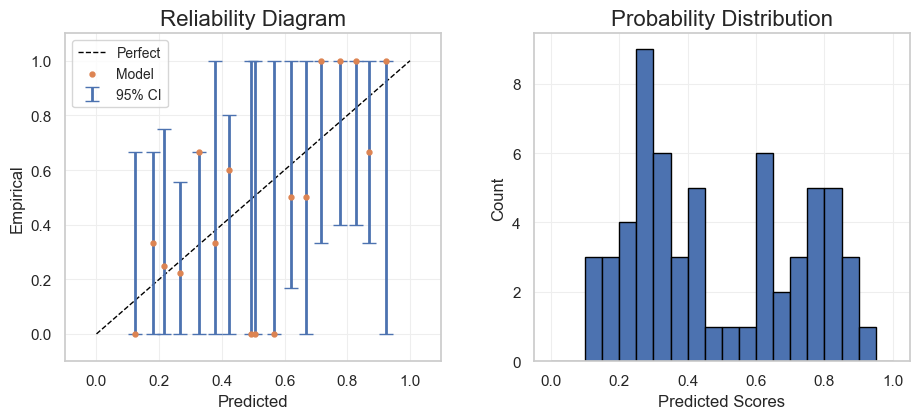

In [51]:
# This is the default plot
plt.figure(figsize=(10,5))
rd = mli.plot_reliability_diagram(y_v, rf1_preds_test_uncalib, show_histogram=True);

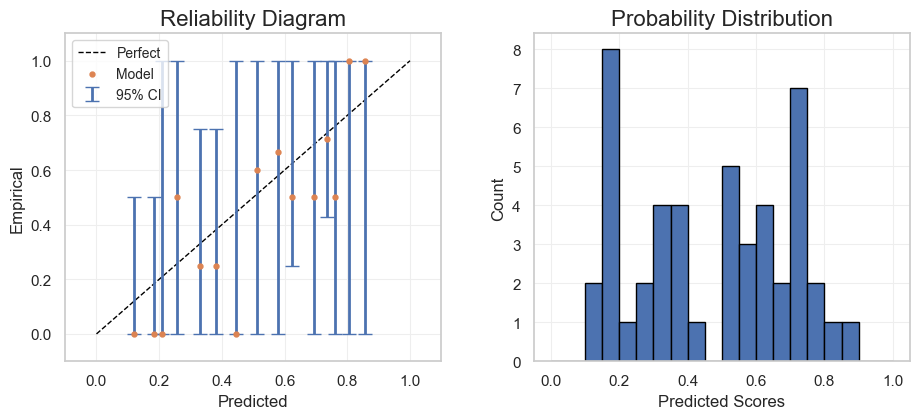

In [52]:
# This is the default plot
plt.figure(figsize=(10,5))
rd = mli.plot_reliability_diagram(y_int_val, rf1_int_val_preds_uncalib, show_histogram=True);

## Lesson 2: Calibrating a Model

Since our models are not well-calibrated, we would like to fix this.

### Getting a Calibration Data Set

We will discuss two ways to get a data set on which to perform calibration:

1. **Use an independent calibration set**
2. **Using Cross-validation to generate scores from the training set**

The first method is simpler but requires a separate data set, meaning that you will have less data to train your model with. It is good to use if you have plenty of data.

The second approach takes more time but is generally more data-efficient. We generate a set of cross-validated predictions on the training data. These predictions come from models that are close to, but not exactly identical to, your original model. However, this discrepancy is usually minor and offset by having more data on which to calibrate.

### Method of Calibration

The data set for calibration is a set of scores and the corresponding binary outcomes. The goal is then to find a function that "fits" the relationship between the scores and the "actual" probabilities (as determined empirically in the calibration set). We will review 4 methods of calibration:

1. **Platt Scaling**
2. **Beta Calibration**
3. **Isotonic Regression**
4. **SplineCalib**

### Approach A: Independent calibration set

**Overall process:**

1. Need separate training and calibration sets (plus a test set to evaluate)
2. Fit model on training set data
3. Make predictions on calibration set
4. Use those predictions + true answers to fit a calibration object
5. Use model to make predictions on test set
6. Use calibrator to calibrate those predictions
7. Evaluate log_loss, reliability diagram on calibrated predictions

In [53]:
calibset_preds_uncalib_1 = ensemble_rf_nc.predict_proba(X_v)
testset_preds_uncalib_1 = ensemble_rf_nc.predict_proba(X_int_val)

## Method 1: Platt Scaling

Assumes that there is a logistic relationship between the scores \(z\) and the true probability \(p\).

$$
\log\left(\frac{p}{1-p}\right) = \alpha + \beta z
$$

$$
p = \frac{1}{1+\exp(-(\alpha + \beta z))}
$$

So it fits the two parameters \(\alpha\) and \(\beta\) just like in logistic regression!

- Very restrictive set of possible functions
- Needs very little data
- Historically, came from the observation (and subsequent theoretical arguments) that a logistic regression was the "right" calibration for Support Vector Machines

Reference: Platt, J. (1999). Probabilistic outputs for support vector machines and comparison to regularized likelihood methods. Advances in Large Margin Classifiers (pp.61–74).

In [54]:
# Fit Platt scaling (logistic calibration)
lr = LogisticRegression(C=99999999999, solver='lbfgs')
lr.fit(calibset_preds_uncalib_1.reshape(-1,1), y_v)

LogisticRegression(C=99999999999)

In [61]:
calibset_platt_probs = lr.predict_proba(calibset_preds_uncalib_1.reshape(-1,1))[:,1]
testset_platt_probs = lr.predict_proba(testset_preds_uncalib_1.reshape(-1,1))[:,1]

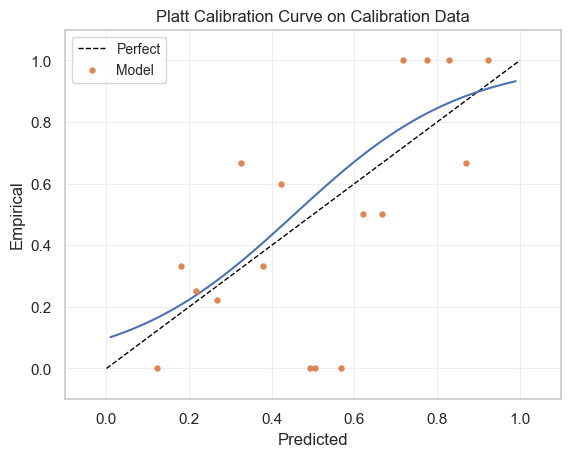

In [64]:
mli.plot_reliability_diagram(y_v, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');

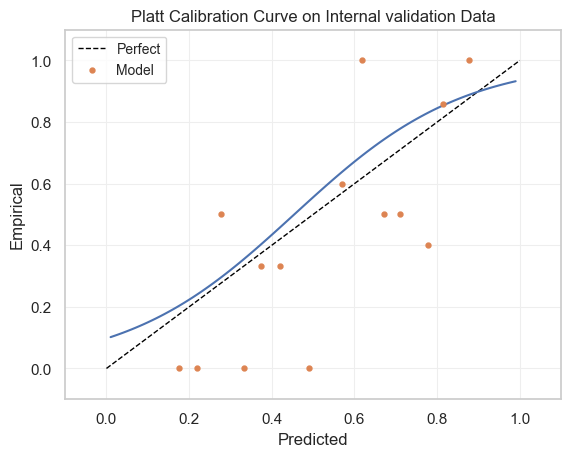

In [67]:
mli.plot_reliability_diagram(y_int_val, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1])
plt.title('Platt Calibration Curve on Internal validation Data');

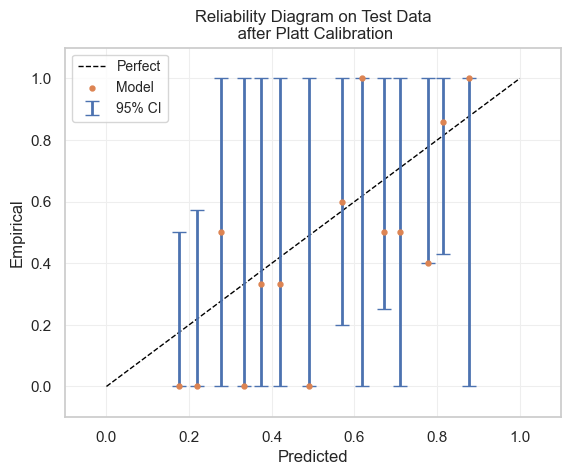

In [66]:
mli.plot_reliability_diagram(y_int_val, testset_platt_probs);
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

In [69]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_int_val, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_int_val, testset_preds_uncalib_1)))

Platt calibrated log_loss = 0.5558990406943595
Uncalibrated log_loss = 0.5332139386811079


## Method 2: Isotonic Regression

- Fits a piecewise constant, monotonically increasing function to map the scores to probabilities.
- Uses the PAV (Pool Adjacent Violators, also called PAVA) algorithm.
- Does not assume a particular parametric form.
- Tends to be better than Platt scaling with enough data.
- Tends to overfit: ("choppy" with unrealistic jumps).

Reference: 
- Zadrozny, B., & Elkan, C. (2001). Obtaining calibrated probability estimates from decision trees and naive bayesian classifiers. ICML (pp.609–616).
- Zadrozny, B., & Elkan, C. (2002). Transforming classifier scores into accurate multiclass probability estimates. KDD (pp.694–699).

In [71]:
iso = IsotonicRegression(out_of_bounds = 'clip')
iso.fit(calibset_preds_uncalib_1, y_v)

IsotonicRegression(out_of_bounds='clip')

In [72]:
calibset_iso_probs = iso.predict(calibset_preds_uncalib_1)
testset_iso_probs = iso.predict(testset_preds_uncalib_1)

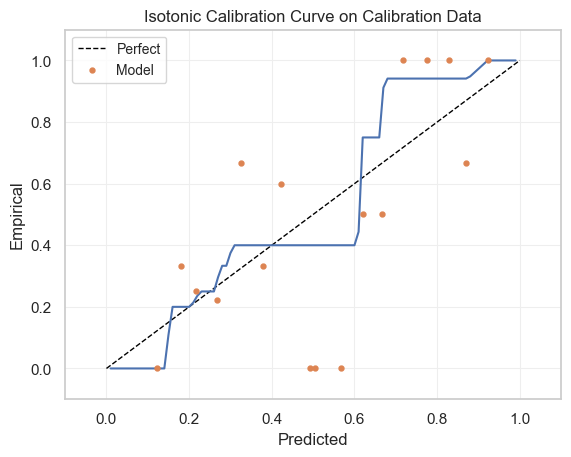

In [73]:
	
mli.plot_reliability_diagram(y_v, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic');
plt.title('Isotonic Calibration Curve on Calibration Data');


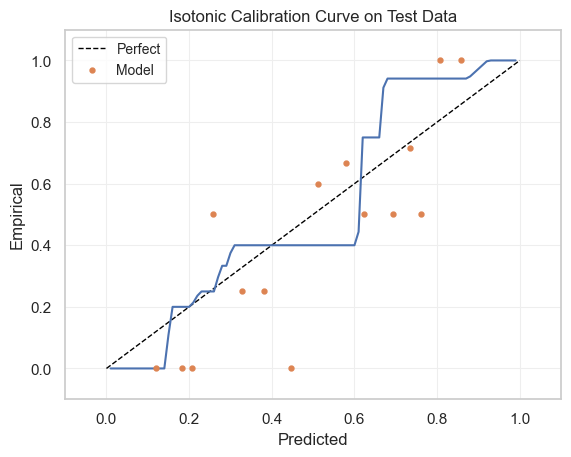

In [74]:
mli.plot_reliability_diagram(y_int_val, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso.predict(tvec), label='Isotonic');
plt.title('Isotonic Calibration Curve on Test Data');

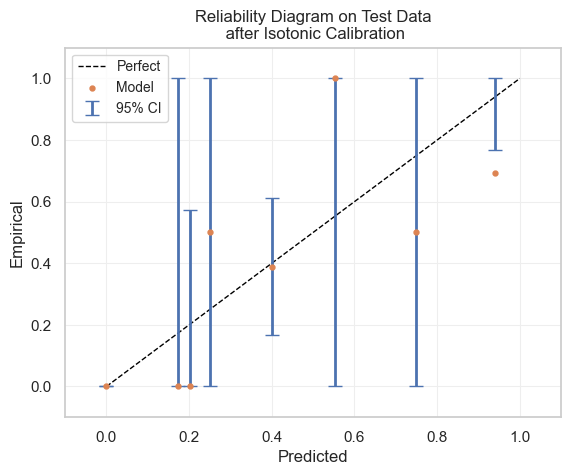

In [75]:
mli.plot_reliability_diagram(y_int_val, testset_iso_probs);
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration');

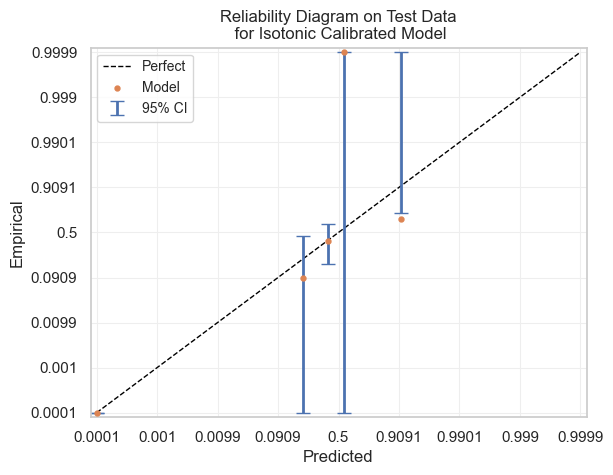

In [76]:
custom_bins_a = np.array([0,.01,.02,.03,.05, .1, .3, .5, .75, 1])
rd = mli.plot_reliability_diagram(y_int_val, testset_iso_probs, scaling='logit', bins=custom_bins_a);
plt.title('Reliability Diagram on Test Data\n for Isotonic Calibrated Model');

In [77]:
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_int_val, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_int_val, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_int_val, testset_preds_uncalib_1)))

Isotonic calibrated log_loss = 0.6342510518478173
Platt calibrated log_loss = 0.5558990406943595
Uncalibrated log_loss = 0.5332139386811079


## Method 3: Beta Calibration

"A well-founded and easily implemented improvement on logistic calibration for binary classifiers."

$$
p = \left(1 + \frac{1}{\exp(c) \frac{z^a}{(1-z)^b}} \right)^{-1}
$$

- Similar to Platt scaling with a couple of important improvements
- Is a 3-parameter family of curves rather than 2-parameter
- Family of curves *includes* the line \( y=x \) (so it won't mess it up if it's already calibrated)

Reference: Kull, M., Filho, T.S. & Flach, P.. (2017). Beta calibration: a well-founded and easily implemented improvement on logistic calibration for binary classifiers. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, in PMLR 54:623-631.

In [78]:
# Fit three-parameter beta calibration
bc = BetaCalibration()
bc.fit(calibset_preds_uncalib_1, y_v)

BetaCalibration()

In [79]:
calibset_bc_probs = bc.predict(calibset_preds_uncalib_1)
testset_bc_probs = bc.predict(testset_preds_uncalib_1)

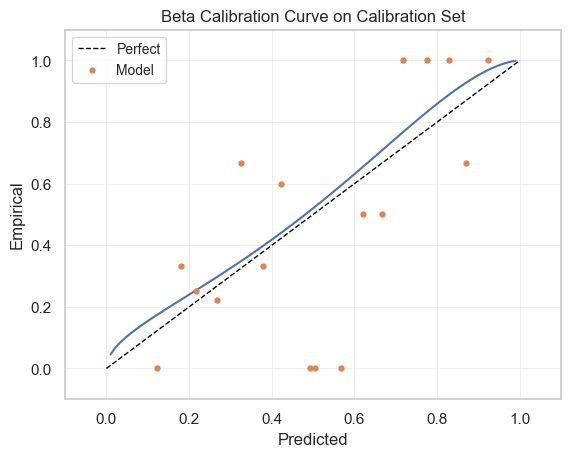

In [80]:
mli.plot_reliability_diagram(y_v, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title('Beta Calibration Curve on Calibration Set');

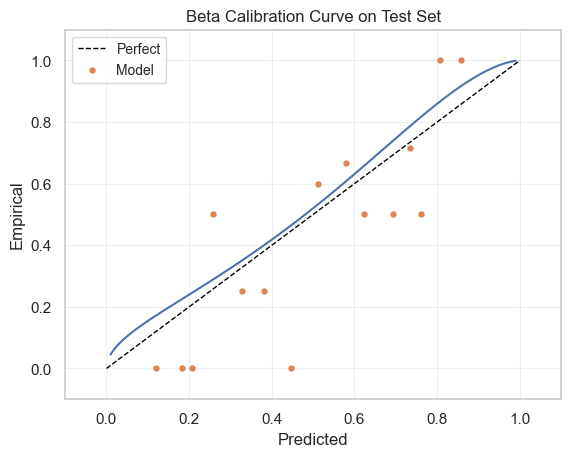

In [82]:
mli.plot_reliability_diagram(y_int_val, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc.predict(tvec))
plt.title('Beta Calibration Curve on Test Set');

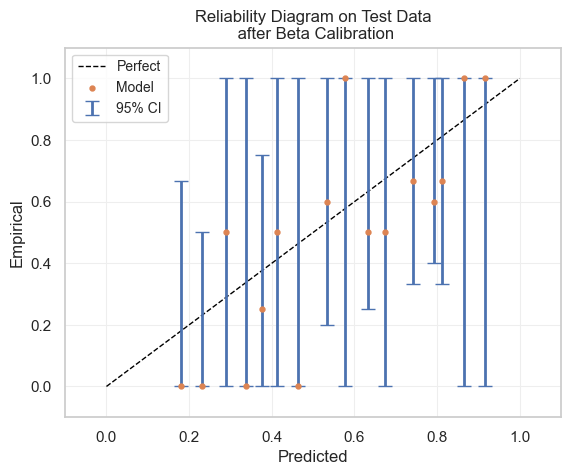

In [83]:
mli.plot_reliability_diagram(y_int_val, testset_bc_probs);
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

In [84]:
print('Beta calibrated log_loss = {}'.format(log_loss(y_int_val, testset_bc_probs)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_int_val, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_int_val, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_int_val, testset_preds_uncalib_1)))

Beta calibrated log_loss = 0.5529525487808872
Isotonic calibrated log_loss = 0.6342510518478173
Platt calibrated log_loss = 0.5558990406943595
Uncalibrated log_loss = 0.5332139386811079


## Method 4: SplineCalib

- SplineCalib fits a cubic smoothing spline to the relationship between the uncalibrated scores and the calibrated probabilities.
- Smoothing splines strike a balance between fitting the points well and having a smooth function.
- SplineCalib uses a smoothed logistic function - so the fit to data is measured by likelihood (i.e., log-loss) and the smoothness refers to the integrated second derivative **before** the logistic transformation.
- There is a nuisance parameter that trades off smoothness for fit. At one extreme, it will revert to standard logistic regression (i.e., Platt scaling) and at the other extreme, it will be a very wiggly function that fits the data but does not generalize well.
- SplineCalib automatically fits the nuisance parameter (though this can be adjusted by the user).
- The resulting calibration function is not necessarily monotonic. (In some cases, this may be beneficial).

References: Lucena, B. Spline-based Probability Calibration. [https://arxiv.org/abs/1809.07751](https://arxiv.org/abs/1809.07751)

In [85]:
# Define SplineCalib object
splinecalib = mli.SplineCalib()
splinecalib.fit(calibset_preds_uncalib_1, y_v)

In [86]:
calibset_splinecalib_probs = splinecalib.predict(calibset_preds_uncalib_1)
testset_splinecalib_probs = splinecalib.predict(testset_preds_uncalib_1)

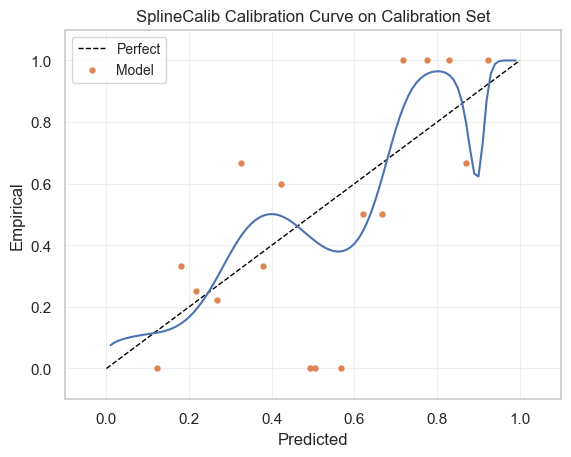

In [91]:
mli.plot_reliability_diagram(y_v, calibset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec))
plt.title('SplineCalib Calibration Curve on Calibration Set');

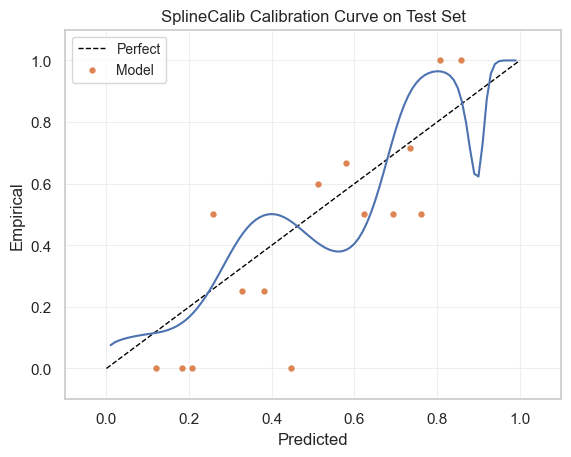

In [94]:
mli.plot_reliability_diagram(y_int_val, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib.predict(tvec))
plt.title('SplineCalib Calibration Curve on Test Set');

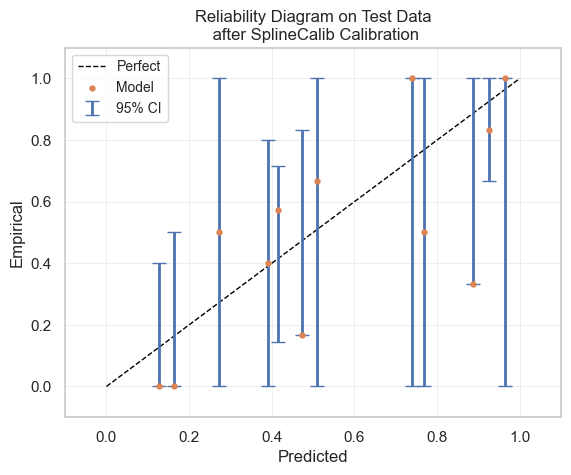

In [95]:
mli.plot_reliability_diagram(y_int_val, testset_splinecalib_probs);
plt.title('Reliability Diagram on Test Data\n after SplineCalib Calibration');

In [97]:
print('Spline calibrated log_loss = {}'.format(log_loss(y_int_val, testset_splinecalib_probs)))
print('Beta calibrated log_loss = {}'.format(log_loss(y_int_val, testset_bc_probs)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(y_int_val, testset_iso_probs)))
print('Platt calibrated log_loss = {}'.format(log_loss(y_int_val, testset_platt_probs)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_int_val, testset_preds_uncalib_1)))

Spline calibrated log_loss = 0.5872608253319694
Beta calibrated log_loss = 0.5529525487808872
Isotonic calibrated log_loss = 0.6342510518478173
Platt calibrated log_loss = 0.5558990406943595
Uncalibrated log_loss = 0.5332139386811079


In [98]:
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(y_int_val, testset_splinecalib_probs)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(y_int_val, testset_bc_probs)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(y_int_val, testset_iso_probs)))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(y_int_val, testset_platt_probs)))
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(y_int_val, testset_preds_uncalib_1)))

Spline calibrated Brier Score = 0.19726094867287733
Beta calibrated Brier Score = 0.18578554639447073
Isotonic calibrated Brier Score = 0.2053254775751438
Platt calibrated Brier Score = 0.18697915508914273
Uncalibrated Brier Score = 0.17869442351968148


## Approach 2: Cross-validation on the Training Data

The reason to use an independent calibration set (rather than just the training data) is that how the model performs on the training data (that it has already seen) is not indicative of how it will behave on data it has not seen before. We want the calibration to correct how the model will behave on "new" data, not the training data.

Another approach is to take a cross-validation approach to generating calibration data. We divide the training data into k "folds", leave one fold out, train our model (i.e., the choice of model and hyperparameter settings) on the remaining k-1 folds, and then make predictions on the left-out fold. After doing this process k times, each time leaving out a different fold, we will have a set of predictions, each of which was generated by one of k slightly different models, but was always generated by a model that did not see that training point. Done properly (assuming no "leakage" across the folds), this set of predictions and answers will serve as an appropriate calibration set.

**Advantages**: 
- More data for both training and calibration.

**Disadvantages**: 
- Must train k+1 models. 
- The calibration data does not come from the exact same model you will be using it on.

ML-Insights (the package containing SplineCalib, as well as other functionality) has a simple function to generate these cross-validated predictions. We demonstrate it below.

# Data Prepration

In [120]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import optuna

df = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

In [121]:
storage_name = "sqlite:///../db.sqlite3_rf"

In [122]:
loaded_study = optuna.create_study(study_name="RF_one_day_assessment_final04", storage=storage_name, load_if_exists=True)

best_params = loaded_study.best_params

[I 2024-08-07 08:06:19,980] Using an existing study with name 'RF_one_day_assessment_final04' instead of creating a new one.


In [125]:
rs=42
rfmodel = RandomForestClassifier(**best_params, random_state=rs)


In [127]:
rfmodel1 = make_pipeline(preprocessor, rfmodel1)
rfmodel1.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'BMI', 'ul_amp',
                                                   'll_amp', 'average_amp',
                                                   'ahd']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['al_N0_Y1',
                                                   'surgery_BCS1MRM2',
                                                   'chemo_No0_Adj1_NAdj2',
                                                   'comorb_no0_cardio1_others2'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=41, min_samples_leaf=8,
                                        min_samples_split=19, n_estimators=116,
                                        random_state=42))])

In [145]:
testset_preds_uncalib_1 = rfmodel1.predict_proba(X_int_val)[:,1]

In [146]:
# Get the cross validated predictions given a model and training data.
cv_preds_train = mli.cv_predictions(rfmodel1, X, y, clone_model=True)
cv_preds_train1 = cv_preds_train[:,1]

In [147]:
# Fit Platt scaling (logistic calibration)
lr_cv = LogisticRegression(C=99999999999, solver='lbfgs')
lr_cv.fit(cv_preds_train1.reshape(-1,1), y)

LogisticRegression(C=99999999999)

In [148]:
testset_platt_probs_cv = lr_cv.predict_proba(testset_preds_uncalib_1.reshape(-1,1))[:,1]

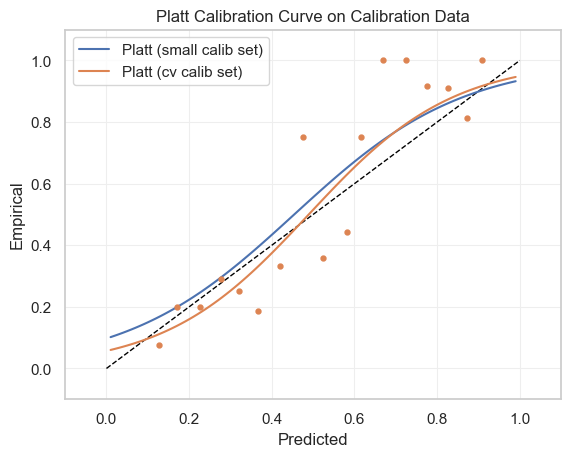

In [149]:
mli.plot_reliability_diagram(y, cv_preds_train1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Platt Calibration Curve on Calibration Data');
plt.legend();

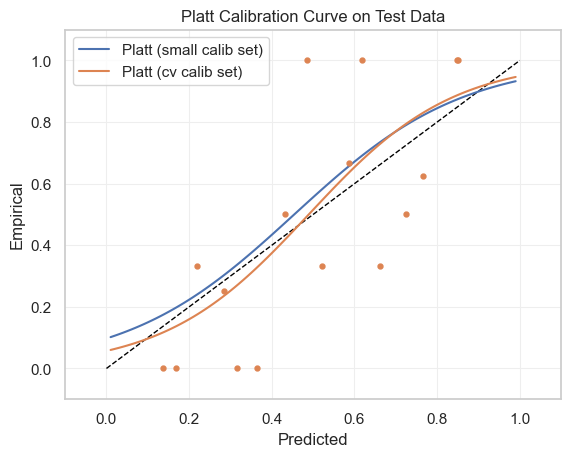

In [150]:
mli.plot_reliability_diagram(y_int_val, testset_preds_uncalib_1, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, lr.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (small calib set)')
plt.plot(tvec, lr_cv.predict_proba(tvec.reshape(-1,1))[:,1], label='Platt (cv calib set)')
plt.title('Platt Calibration Curve on Test Data');
plt.legend();

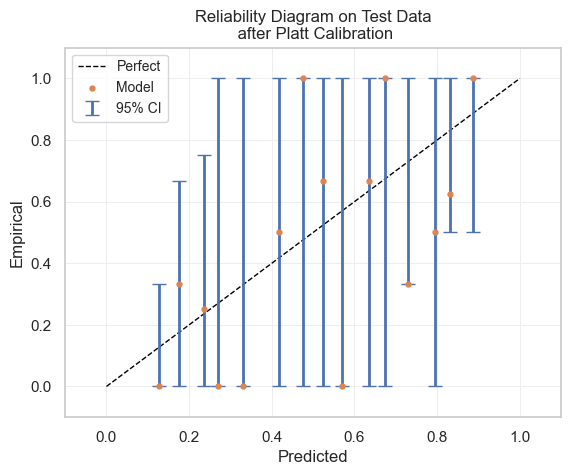

In [151]:
mli.plot_reliability_diagram(y_int_val, testset_platt_probs_cv);
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

In [152]:
print('Platt calibrated log_loss = {}'.format(log_loss(y_int_val, testset_platt_probs_cv)))
print('Uncalibrated log_loss = {}'.format(log_loss(y_int_val, testset_preds_uncalib_1)))

Platt calibrated log_loss = 0.5498316931609258
Uncalibrated log_loss = 0.5406412389931774
